In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/sentiment_data.zip

In [ ]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import contractions
import re
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from keras import Input, Model
from keras.models import load_model
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
stopword_list = stopwords.words('english')
tokenizer = wordpunct_tokenize

nlp = spacy.load('en', parse=True, tag=True, entity=True)

lst = ['no', 'not', 'nor', 'very', 'too', 'ain\'', 'ain\'t']
stopword_list = [s for s in stopword_list if s not in lst]

In [ ]:
TOTAL_LEN = 2048
BATCH_SIZE = 64

In [ ]:
def get_data_dic(folder):
  y = list()
  x = list()
  data = dict()
  base_path = os.path.join('sentiment_data', folder)
  for path in os.listdir(base_path):
    for files in [os.path.join(base_path, path, f) for f in os.listdir(os.path.join(base_path, path))]:
      file = open(files, 'r').read()
      x.append(file)
      if path == 'neg':
        y.append(0)
      elif path == 'pos':
        y.append(1)

  data['text'] = x
  data['sentiment'] = y
  return pd.DataFrame(data).sample(frac=1).reset_index(drop=True)

In [ ]:
train_df = get_data_dic('train')
test_df = get_data_dic('test')

In [ ]:
print(train_df.shape)
train_df.head()

(35769, 2)


,text,sentiment
0,Almost 30 years later I recall this original P...,1
1,Every scene was put together perfectly.This mo...,1
2,I have to agree with the other two comments. I...,0
3,"Well, of course not, women are overly sensitiv...",1
4,This is one of the best musicals of the 1940s....,1


In [ ]:
print(test_df.shape)
test_df.head()

(10000, 2)


,text,sentiment
0,This movie is such a total waste of time. I ca...,0
1,"The only thing in ""Sudden Death"" that outdoes ...",0
2,I was a still photographer working in Europe t...,0
3,RKO Radio Pictures made a real classic in 1947...,1
4,Total Garbage!!! No reflection to Washington h...,0


In [ ]:
def remove_html_tags(text):
  return BeautifulSoup(text, 'html.parser').get_text()

def remove_contraction(text):
  return contractions.fix(text)

def remove_special_characters(text):
  return re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', text)

def remove_punctuation(text):
  return ''.join([c for c in text if c not in string.punctuation])

def get_lem(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

def get_stem(text):
  stemmer = nltk.porter.PorterStemmer()
  text = ' '.join([stemmer.stem(word) for word in text.split()])
  return text

def remove_stopwords(text):
  tokens = wordpunct_tokenize(text)
  tokens = [token.strip() for token in tokens]
  tok = [token for token in tokens if token.lower() not in stopword_list]
  return ' '.join(tok)

def remove_extra_whitespace_tabs(text): 
  return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def to_lowercase(text):
  return text.lower()

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: remove_html_tags(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_contraction(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_special_characters(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_punctuation(x))
train_df['text'] = train_df['text'].apply(lambda x: x.replace('\n', ' '))
train_df['text'] = train_df['text'].apply(lambda x: get_lem(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_stopwords(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_extra_whitespace_tabs(x))
train_df['text'] = train_df['text'].apply(lambda x: to_lowercase(x))

In [ ]:
train_df.head(10)

,text,sentiment
0,almost 30 year later recall original pbs film ...,1
1,every scene put together perfectlythis movie w...,1
2,agree two comment wait month see great new sho...,0
3,well course not woman overly sensitive needy a...,1
4,one good musical 1940 glorious technicolor sho...,1
5,jimmy stewart real life pilot wwii flier onest...,1
6,czech cinematography travel dark time movie ta...,0
7,arnold fan holler joy fan brainless action hol...,0
8,terminus paradis exceptional niki ardelean com...,0
9,five year ago friend go video rental store get...,0


In [ ]:
def process_text_data(text,
                      html_tag_remove=True,
                      contraction=True,
                      remove_spcl_char=True,
                      remove_punct=True,
                      remove_newline_char=True,
                      root_word='lemm',
                      remove_stopword=True,
                      remove_extra_space=True,
                      to_lower=True):
  '''
  For `root_word` argument type:
    "lemm" for Lemmarization; &
    "stem" for Stemming.
  '''
  if html_tag_remove:
    text = BeautifulSoup(text, 'html.parser').get_text()
  if contraction:
    text = contractions.fix(text)
  if remove_spcl_char:
    text = re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', text)
  if remove_punct:
    text = ''.join([c for c in text if c not in string.punctuation])
  if remove_newline_char:
    text = text.replace('\n', ' ')
  if root_word == 'lemm':
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  elif root_word == 'stem':
    text = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
  else:
    raise Exception('Root Word is wrong.')
  if remove_stopword:
    tokens = tokenizer(text)
    tokens = [token.strip() for token in tokens]
    tok = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(tok)
  if remove_extra_space:
    text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
  if to_lower:
    text = text.lower()

  return text

In [ ]:
test_df['text'] = test_df['text'].apply(lambda x: process_text_data(x))

In [ ]:
# def corpus_gen():
#   for i, row in train_df.iterrows():
#     yield row['text']

# tokenizer_sentiment = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_gen(), target_vocab_size=2**13)

# tokenizer_sentiment.save_to_file('sentiment')

In [ ]:
tokenizer_sentiment = tfds.deprecated.text.SubwordTextEncoder.load_from_file('sentiment')

In [ ]:
def encoding_and_padding(text):
  en_text = [tokenizer_sentiment.vocab_size] + tokenizer_sentiment.encode(text)
  if len(en_text) < TOTAL_LEN:
    en_text = en_text + [0] * (TOTAL_LEN - len(en_text) - 1) + [tokenizer_sentiment.vocab_size + 1]
  else:
    en_text = en_text[:TOTAL_LEN-1] + [tokenizer_sentiment.vocab_size + 1]
  return en_text

#Naive Bayes

In [ ]:
naive_df = train_df.copy()
naive_df['encoded_text'] = naive_df['text'].apply(lambda x: encoding_and_padding(x))
naive_df.drop('text', axis=1, inplace=True)

In [ ]:
naive_df.head()

,sentiment,encoded_text
0,1,"[8232, 371, 1112, 11, 253, 3796, 72, 4704, 51,..."
1,0,"[8232, 24, 1, 58, 607, 2169, 3116, 3856, 204, ..."
2,1,"[8232, 1, 1387, 308, 8026, 274, 232, 304, 2713..."
3,0,"[8232, 115, 490, 993, 434, 1625, 1, 270, 2729,..."
4,0,"[8232, 1557, 140, 4182, 146, 3191, 26, 146, 71..."


In [ ]:
def get_data_x_y(df):
  x = np.asarray([r['encoded_text'] for i, r in df.iterrows()])
  y = np.asarray(df['sentiment'])
  return x, y

In [ ]:
naive_train_x, naive_train_y = get_data_x_y(naive_df)

In [ ]:
gnb = GaussianNB()
mnb = MultinomialNB()

In [ ]:
gnb.fit(naive_train_x, naive_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
mnb.fit(naive_train_x, naive_train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
naive_test = test_df.copy()
naive_test['encoded_text'] = naive_test['text'].apply(lambda x: encoding_and_padding(x))
naive_test.drop('text', axis=1, inplace=True)

In [ ]:
naive_test.head()

,sentiment,encoded_text
0,0,"[8232, 4, 1193, 1309, 3868, 8008, 4927, 3, 195..."
1,0,"[8232, 51, 2, 3658, 12, 3337, 66, 2, 26, 164, ..."
2,1,"[8232, 19, 159, 7788, 270, 26, 7107, 2065, 380..."
3,0,"[8232, 29, 259, 239, 385, 100, 5379, 2100, 593..."
4,1,"[8232, 6, 1437, 6476, 129, 669, 1835, 1213, 21..."


In [ ]:
naive_testx, naive_testy = get_data_x_y(naive_test)

In [ ]:
pred_y_gnb = gnb.predict(naive_testx)
pred_y_mnb = mnb.predict(naive_testx)

In [ ]:
print('GNB: ', accuracy_score(naive_testy, pred_y_gnb))
print('MNB: ', accuracy_score(naive_testy, pred_y_mnb))

GNB:  0.5019
MNB:  0.5107


GNB Classification Report:
```
              precision    recall  f1-score   support

           0       0.50      0.99      0.67      5000
           1       0.62      0.01      0.02      5000

    accuracy                           0.50     10000
   macro avg       0.56      0.50      0.34     10000
weighted avg       0.56      0.50      0.34     10000
```

MNB Classification Report:
```
              precision    recall  f1-score   support

           0       0.51      0.89      0.64      5000
           1       0.54      0.13      0.21      5000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.43     10000
weighted avg       0.52      0.51      0.43     10000
```

In [ ]:
dump(mnb, 'naive.joblib')

['naive.joblib']

#LSTM

In [ ]:
train_df['encoded_text'] = train_df['text'].apply(lambda x: encoding_and_padding(x))
train_df.drop('text', axis=1, inplace=True)
train_df.head()

,sentiment,encoded_text
0,1,"[8232, 371, 1112, 11, 253, 3796, 72, 4704, 51,..."
1,0,"[8232, 24, 1, 58, 607, 2169, 3116, 3856, 204, ..."
2,1,"[8232, 1, 1387, 308, 8026, 274, 232, 304, 2713..."
3,0,"[8232, 115, 490, 993, 434, 1625, 1, 270, 2729,..."
4,0,"[8232, 1557, 140, 4182, 146, 3191, 26, 146, 71..."


In [ ]:
test_df['encoded_text'] = test_df['text'].apply(lambda x: encoding_and_padding(x))
test_df.drop('text', axis=1, inplace=True)
test_df.head()

,sentiment,encoded_text
0,0,"[8232, 4, 1193, 1309, 3868, 8008, 4927, 3, 195..."
1,0,"[8232, 51, 2, 3658, 12, 3337, 66, 2, 26, 164, ..."
2,1,"[8232, 19, 159, 7788, 270, 26, 7107, 2065, 380..."
3,0,"[8232, 29, 259, 239, 385, 100, 5379, 2100, 593..."
4,1,"[8232, 6, 1437, 6476, 129, 669, 1835, 1213, 21..."


In [ ]:
def model_data_gen(df):
  while True:
    df_sample = df.sample(n=BATCH_SIZE)
    x, y = get_data_x_y(df_sample)
    
    yield x, y

In [ ]:
p, q = next(model_data_gen(train_df))

In [ ]:
print('Text Batch Sequence Shape: ', p.shape)
print('Corresponding Sentiment Batch Shape: ', q.shape)

Text Batch Sequence Shape:  (64, 2048)
Corresponding Sentiment Batch Shape:  (64,)


In [ ]:
train_gen = model_data_gen(train_df)
val_gen = model_data_gen(test_df)

In [ ]:
VOCAB_SIZE = tokenizer_sentiment.vocab_size + 2
EMB_SIZE = 128

In [ ]:
inputs = Input((TOTAL_LEN))
x = Embedding(VOCAB_SIZE, EMB_SIZE)(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation="sigmoid")(x)

model_lstm = Model(inputs, outputs)

model_lstm.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 2048, 128)         1053952   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 2048, 128)         98816     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0   

In [ ]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
lr_red = ReduceLROnPlateau(patience=3, factor=0.01, monitor='val_accuracy')

In [ ]:
hist = model_lstm.fit(train_gen, epochs=100, steps_per_epoch=64, validation_data=val_gen,
                      validation_steps=64, callbacks=[early_stop, lr_red])

Epoch 1/100
64/64 [==============================] - 37s 484ms/step - loss: 0.6866 - accuracy: 0.5293 - val_loss: 0.5360 - val_accuracy: 0.7451
Epoch 2/100
64/64 [==============================] - 29s 456ms/step - loss: 0.5304 - accuracy: 0.7675 - val_loss: 0.4645 - val_accuracy: 0.7925
Epoch 3/100
64/64 [==============================] - 29s 460ms/step - loss: 0.4629 - accuracy: 0.8131 - val_loss: 0.4328 - val_accuracy: 0.8098
Epoch 4/100
64/64 [==============================] - 29s 463ms/step - loss: 0.4222 - accuracy: 0.8320 - val_loss: 0.4264 - val_accuracy: 0.8213
Epoch 5/100
64/64 [==============================] - 29s 458ms/step - loss: 0.4433 - accuracy: 0.8223 - val_loss: 0.4528 - val_accuracy: 0.8123
Epoch 6/100
64/64 [==============================] - 29s 463ms/step - loss: 0.4058 - accuracy: 0.8441 - val_loss: 0.4783 - val_accuracy: 0.8091
Epoch 7/100
64/64 [==============================] - 29s 457ms/step - loss: 0.3715 - accuracy: 0.8623 - val_loss: 0.3899 - val_accuracy:

In [ ]:
def res(result):
  if result > 0.5:
    print('positive')
  else:
    print('negative')

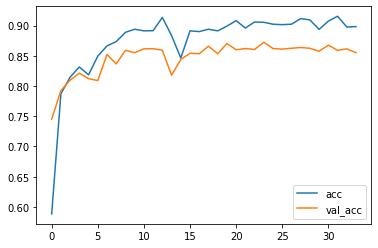

In [ ]:
p1 = plt.plot(range(len(hist.history['accuracy'])), hist.history['accuracy'])
p2 = plt.plot(range(len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

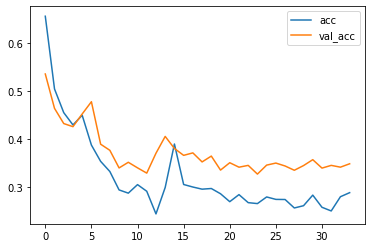

In [ ]:
p1 = plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
p2 = plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [ ]:
model_lstm.save('model_lstm.h5')

In [ ]:
a = """I watched a movie today and it was an amazing movie. In it the hero was fighting here and there. I love it."""
b = """I hate that movie as it was pretty boring story. I didn't know what was going on in the movie."""

a = encoding_and_padding(process_text_data(a))
b = encoding_and_padding(process_text_data(b))

a = np.expand_dims(np.array(a), axis=0)
b = np.expand_dims(np.array(b), axis=0)

ar = model_lstm.predict(a)
br = model_lstm.predict(b)

In [ ]:
res(ar)

positive


In [ ]:
res(br)

negative
